## Sentiment Analysis and Prediction of Review Ratings on the Epinion Dataset

In [1]:
#importing all necessary libraries and package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import  TfidfTransformer,CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
import string

In [2]:
# import sys
# sys.path.append('/home/013767416/.local/lib/python2.7/site-packages')
# !pip3 install --user pyspark
#!pip3 install --user WordCloud
# !pip install --user  stop_words
# !pip install --user vaderSentiment
# !pip install --user xgboost
# !pip install pyspark
# !conda install -y -c --user conda-forge twython
# !pip install --user textblob
# !python -m textblob.download_corpora
# !python -m textblob.download_corpora
# Install spaCy (run in terminal/prompt)
# !{sys.executable} -m pip install --user spacy
# # # Download spaCy's  'en' Model
# !{sys.executable} -m spacy download --user en

In [57]:
import pyspark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, pandas_udf,PandasUDFType
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [34]:
# findspark.init('/home/013767416/.local/lib/python2.7/site-packages/pyspark/')

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('crubadan')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [29]:
# Calling spark session to register application
spark = SparkSession \
    .builder \
    .appName("Recom") \
    .config("spark.recom.demo", "1") \
    .getOrCreate()

In [61]:
# Load data using pyspark
epinion_spark_df = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("epinion_data_preprocessed.csv")

In [62]:
epinion_spark_df.show(3)

[Row(item='pr-Sony_KV_36FS12__Standard_Televisions', paid='1199', review='well when i graduated from college it didnt take me long to realize that my 15 inch tvvcr combo from the old dorm room wasnt gonna quite cut it in the real world so it was on to best buy', stars=5, time=1012262400, user='pyros7'),
 Row(item='Minolta_QMS_PagePro_1250E_Printers', paid='260', review='i got this printer from minolta as a warranty replacement for the minolta pagepro 1100l which didnt work under windows xp the unit is a little bulkier than the 1100l also the paper tray is fully enclosed however the plastic hinged top does not close as fully as the 1100l did and more dust gets into the printer', stars=4, time=1027296000, user='fgb59h'),
 Row(item='Sony_VAIO_PCG_K45_P4_538_3_2GHz_1MB_L2_533MHz_FSB_512MB_80GB_DVD_CDRW_56K_NIC_802_11bg_15_4_WXGA_XB_XP_PC_Notebook', paid='1800', review='although i love my vaio especially the gorgeous display there are several things about it that would cause me to choose an

In [3]:
# load the dataset
# file_path = 'epinions_with_quotes.json'
# epinion_data = pd.read_json(file_path, lines=True)
# epinion_data.head(3)
epinion_data = pd.read_csv('epinion_data_preprocessed.csv')
epinion_data.head(3)

,item,paid,review,stars,time,user
0,pr-Sony_KV_36FS12__Standard_Televisions,1199,well when i graduated from college it didnt ta...,5,1012262400,pyros7
1,Minolta_QMS_PagePro_1250E_Printers,260,i got this printer from minolta as a warranty ...,4,1027296000,fgb59h
2,Sony_VAIO_PCG_K45_P4_538_3_2GHz_1MB_L2_533MHz_...,1800,although i love my vaio especially the gorgeou...,2,1201305600,bucho_ky


In [ ]:
print('Rows:', epinion_data.shape[0], '; Columns:', epinion_data.shape[1], '\n')
epinion_spark_df.count()

In [5]:
epinion_data.head(5)
# epinion_spark_df.show(5)

,item,paid,review,stars,time,user
0,pr-Sony_KV_36FS12__Standard_Televisions,1199,well when i graduated from college it didnt ta...,5,1012262400,pyros7
1,Minolta_QMS_PagePro_1250E_Printers,260,i got this printer from minolta as a warranty ...,4,1027296000,fgb59h
2,Sony_VAIO_PCG_K45_P4_538_3_2GHz_1MB_L2_533MHz_...,1800,although i love my vaio especially the gorgeou...,2,1201305600,bucho_ky
3,Sony_VAIO_PCG_K45_P4_538_3_2GHz_1MB_L2_533MHz_...,1000,this is my first laptop and i bought it about ...,4,1118016000,redp944
4,pr-Durabrand_CD-85_Personal_CD_Player,20,just recently my sony dej001 walkman died on m...,4,1149292800,spongebag7


### Dataset Information:

In [8]:
epinion_data.columns

Index([u'item', u'paid', u'review', u'stars', u'time', u'user'], dtype='object')

In [10]:
print('No. of Unique Users :', epinion_data.user.nunique())
print('No. of Unique Items :', epinion_data.item.nunique())
print('No. of Unique Ratings  :', epinion_data.stars.nunique())

('No. of Unique Users :', 116259)
('No. of Unique Items :', 41269)
('No. of Unique Ratings  :', 5)


In [16]:
stars_count = epinion_data.groupby(by=['stars']).agg({'user': 'count'}).reset_index()
stars_count.columns = ['Stars', 'Count']
print(stars_count)

   Stars  Count
0      1  33304
1      2  15091
2      3  17151
3      4  47311
4      5  75626


In [200]:
stars_count = epinion_spark_df.groupBy('stars').agg({'user': 'count'})
print(stars_count)
epinion_spark_df.show(5)

DataFrame[stars: int, count(user): bigint]
+--------------------+----+--------------------+-----+----------+----------+
|                item|paid|              review|stars|      time|      user|
+--------------------+----+--------------------+-----+----------+----------+
|pr-Sony_KV_36FS12...|1199|well when i gradu...|    5|1012262400|    pyros7|
|Minolta_QMS_PageP...| 260|i got this printe...|    4|1027296000|    fgb59h|
|Sony_VAIO_PCG_K45...|1800|although i love m...|    2|1201305600|  bucho_ky|
|Sony_VAIO_PCG_K45...|1000|this is my first ...|    4|1118016000|   redp944|
|pr-Durabrand_CD-8...|  20|just recently my ...|    4|1149292800|spongebag7|
+--------------------+----+--------------------+-----+----------+----------+
only showing top 5 rows



### Creating a new column 
- The new column will be - "length". 
- This column will hold the data of the word length of the review.

In [201]:
epinion_data['text length'] = epinion_data['review'].apply(len)
epinion_data.head(3)

,item,paid,review,stars,time,user,text length
0,pr-Sony_KV_36FS12__Standard_Televisions,1199,well when i graduated from college it didnt ta...,5,1012262400,pyros7,186
1,Minolta_QMS_PagePro_1250E_Printers,260,i got this printer from minolta as a warranty ...,4,1027296000,fgb59h,311
2,Sony_VAIO_PCG_K45_P4_538_3_2GHz_1MB_L2_533MHz_...,1800,although i love my vaio especially the gorgeou...,2,1201305600,bucho_ky,177


In [74]:
epinion_spark_df.withColumn('text length', F.length('review')).show(3)

+--------------------+----+--------------------+-----+----------+--------+-----------+
|                item|paid|              review|stars|      time|    user|text length|
+--------------------+----+--------------------+-----+----------+--------+-----------+
|pr-Sony_KV_36FS12...|1199|well when i gradu...|    5|1012262400|  pyros7|        186|
|Minolta_QMS_PageP...| 260|i got this printe...|    4|1027296000|  fgb59h|        311|
|Sony_VAIO_PCG_K45...|1800|although i love m...|    2|1201305600|bucho_ky|        177|
+--------------------+----+--------------------+-----+----------+--------+-----------+
only showing top 3 rows



### Visualization

- Let us now visualize the if there is any correlation between stars and the length of the review.

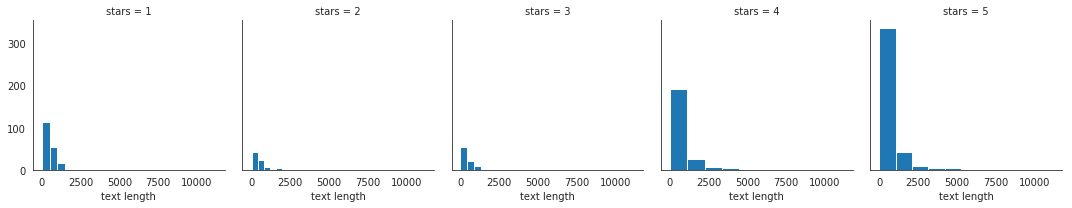

In [77]:
g = sns.FacetGrid(epinion_data,col='stars')
g.map(plt.hist,'text length')

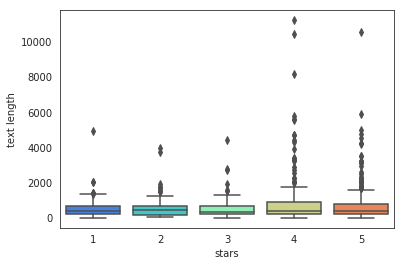

In [78]:
sns.boxplot(x='stars',y='text length',data=epinion_data,palette='rainbow')

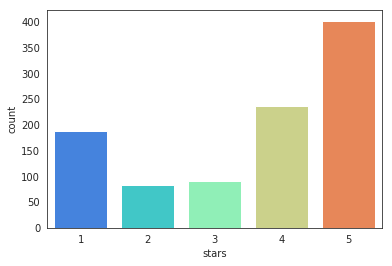

In [79]:
sns.countplot(x='stars',data=epinion_data,palette='rainbow')

In [80]:
stars = epinion_data.groupby('stars').mean()
stars

,time,text length
stars,,
1,1.165676e+09,510.614973
2,1.128368e+09,599.385542
3,1.131049e+09,566.021978
4,1.119838e+09,882.700422
5,1.118234e+09,683.485075


,time,text length
time,1.000000,-0.959252
text length,-0.959252,1.000000


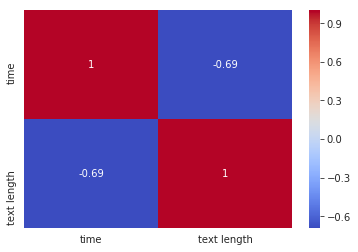

In [81]:
sns.heatmap(stars.corr(),cmap='coolwarm',annot=True)

In [31]:
# !pip install --user  stop_words
# import sys
# sys.path.append('/home/013767416/.local/lib/python3.7/site-packages')

You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Text Pre-processing

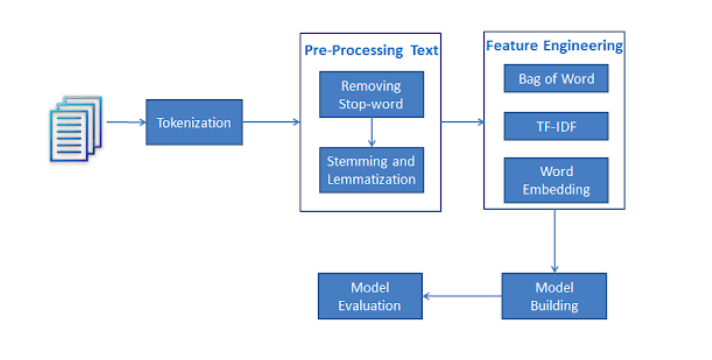

In [100]:
from IPython.display import Image
Image(filename='image.png')

### Data Cleaning and preprocessing using NLTK:
We will now, define a function which will clean the dataset by removing stopwords and punctuations.
The process of converting data to something a computer can understand is referred to as pre-processing.
- One of the major forms of pre-processing is to filter out useless data. 
- In natural language processing, useless words (data), are referred to as stop words.
- We would not want these words taking up space in our database, or taking up valuable processing time. 
- For this, we can remove them easily, by storing a list of words that you consider to be stop words.

### Data Preprocessing steps for text classification:
- Tokenization - The process of breaking down a text paragraph into smaller chunks such as words or sentence is called Tokenization. Token is a single entity that is building blocks for sentence or paragraph.
- Removing non-English words from reviews
- Removing stop words - Stopwords are  considered as noise in the text.(as is, am, are, this, a, an, the, etc.)
- Lemmatize a Sentence with the appropriate POS tag

### Stemming and Lemmatization
- Lemmatization reduces words to their base word, which is linguistically correct lemmas. 
- It transforms root word with the use of vocabulary and morphological analysis. 
- Lemmatization is more sophisticated than stemming. 
- Stemmer works on an individual word without knowledge of the context. 
- For example, The word "better" has "good" as its lemma. This thing will miss by stemming because it requires a dictionary look-up.

In [10]:
# Lemmatization https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
lemmatizer = WordNetLemmatizer()

def cleaned_review(review):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned review
    4. Lemmatize
    """
    processed_review = []
    for word in review.split():
        # removing punctuations
        word = [char for char in word if char not in string.punctuation]       
        word= "".join(word)
        # removing stop words
        if word.lower() not in stopwords.words('english'):
            # Lemmatize a Sentence with the appropriate POS tag
            word = lemmatizer.lemmatize(word, get_wordnet_part_of_speech(word))
            # removing 1 letter words
            if len(word) > 1:
                processed_review.append(word)
                
    # join everything
    processed_review = " ".join(processed_review)
    return (processed_review)

# Lemmatize with POS Tag
def get_wordnet_part_of_speech(word):
    """Map Part-of-Speech tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


### Sentiment Analysis
- If you want to understand your customers then you have to be able to possess a strong capability to analyze text.
- Sentiment Analysis tries to identify and extract opinions within a given text. The aim of sentiment analysis is to gauge the attitude, sentiments, evaluations, attitudes and emotions of a speaker/writer based on the computational treatment of subjectivity in a text.



In [11]:
# https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
# http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf
sentiment_analyzer = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = sentiment_analyzer.polarity_scores(sentence)['compound']
    return(float(score))

# sentiment_analyzer_compound_score("The phone is super cool.") #eaxmple

- The results of VADER analysis are not only remarkable but also very encouraging. 
- The outcomes highlight the tremendous benefits that can be attained by the use of VADER in cases of micro-blogging sites wherein the text data is a complex mix of a variety of text.

In [12]:
def calculate_sentiment(polarity):
    if polarity >= -1 and polarity <= -0.6:
        sentiment = 1
    elif polarity >= -0.6 and polarity <= -0.2:
        sentiment = 2
    elif polarity >= -0.2 and polarity <= 0.2:
        sentiment = 3
    elif polarity >= 0.2 and polarity <= 0.6:
        sentiment = 4
    else:
        sentiment = 5
    return sentiment
# plt.figure(figsize=(10,10))
# sns.set_style("whitegrid")
# ax = sns.countplot(x="Sentiment_Type", data=epinion_data_title)

In [35]:
# https://textblob.readthedocs.io/en/dev/quickstart.html
# https://textblob.readthedocs.io/en/dev/install.html
from textblob import TextBlob
def calculatePolarty(text):
    blob = TextBlob(text)
    blob.tags           # [('The', 'DT'), ('titular', 'JJ'),
                        #  ('threat', 'NN'), ('of', 'IN'), ...]
    blob.noun_phrases   # WordList(['titular threat', 'blob',
                        #            'ultimate movie monster',
                        #            'amoeba-like mass', ...])
    for sentence in blob.sentences:
        return(sentence.sentiment.polarity)

In [36]:
calculatePolarty("Movie was very very great")

1.0

##### Text cleaning

In [15]:
epinion_data['cleaned_review'] = epinion_data['review'].apply(cleaned_review)
# epinion_spark_df.select(cleaned_review(col("review"))).show()

##### Calculating polarity using Vader Sentiment Analyzer

In [16]:
epinion_data['polarity'] = epinion_data['cleaned_review'].apply(sentiment_analyzer_scores)

#####  Calculating sentiment rating based on polarity

In [17]:
epinion_data['sentiment'] = epinion_data['polarity'].apply(calculate_sentiment)

In [19]:
epinion_data.head(3)

,item,paid,review,stars,time,user,cleaned_review,polarity,sentiment
0,pr-Sony_KV_36FS12__Standard_Televisions,1199,well when i graduated from college it didnt ta...,5,1012262400,pyros7,well graduate college didnt take long realize ...,0.8090,5
1,Minolta_QMS_PagePro_1250E_Printers,260,i got this printer from minolta as a warranty ...,4,1027296000,fgb59h,get printer minolta warranty replacement minol...,-0.0987,3
2,Sony_VAIO_PCG_K45_P4_538_3_2GHz_1MB_L2_533MHz_...,1800,although i love my vaio especially the gorgeou...,2,1201305600,bucho_ky,although love vaio especially gorgeous display...,0.8883,5


In [22]:
epinion_data.to_csv('epinion_processed_new.csv', index = False)

#####  Calculating polarity using Textblob

In [37]:
epinion_data['textblob_polarity'] = epinion_data['review'].apply(calculatePolarty)

#####  Calculating sentiment rating based on textblob polarity

In [38]:
epinion_data['textblob_sentiment'] = epinion_data['textblob_polarity'].apply(calculate_sentiment)

In [39]:
epinion_data['sentiment'].unique()

array([5, 3, 4, 2, 1])

In [40]:
epinion_data.head(5)

,item,paid,review,stars,time,user,cleaned_review,polarity,sentiment,textblob_polarity,textblob_sentiment
0,pr-Sony_KV_36FS12__Standard_Televisions,1199,well when i graduated from college it didnt ta...,5,1012262400,pyros7,well graduate college didnt take long realize ...,0.8090,5,0.312500,4
1,Minolta_QMS_PagePro_1250E_Printers,260,i got this printer from minolta as a warranty ...,4,1027296000,fgb59h,get printer minolta warranty replacement minol...,-0.0987,3,0.270833,4
2,Sony_VAIO_PCG_K45_P4_538_3_2GHz_1MB_L2_533MHz_...,1800,although i love my vaio especially the gorgeou...,2,1201305600,bucho_ky,although love vaio especially gorgeous display...,0.8883,5,0.240000,4
3,Sony_VAIO_PCG_K45_P4_538_3_2GHz_1MB_L2_533MHz_...,1000,this is my first laptop and i bought it about ...,4,1118016000,redp944,first laptop bought two month ago portable des...,0.8555,5,0.527143,4
4,pr-Durabrand_CD-85_Personal_CD_Player,20,just recently my sony dej001 walkman died on m...,4,1149292800,spongebag7,recently sony dej001 walkman die pretty good p...,0.9767,5,0.157068,3


##### Stars count based on textblob polarity

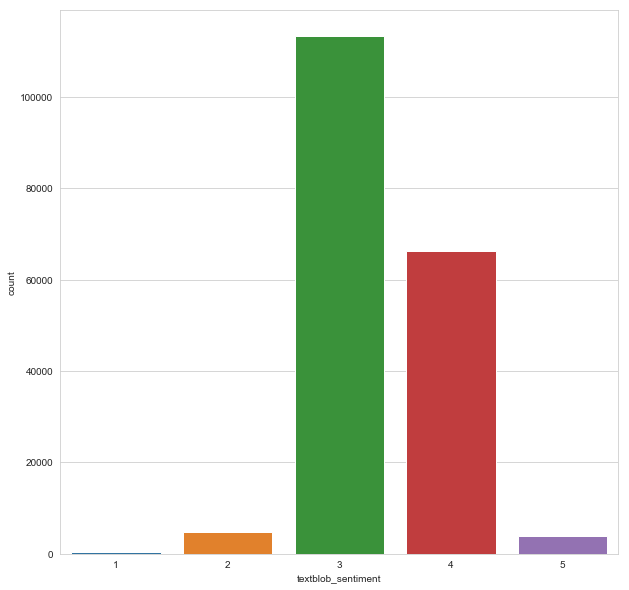

In [41]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="textblob_sentiment", data=epinion_data)

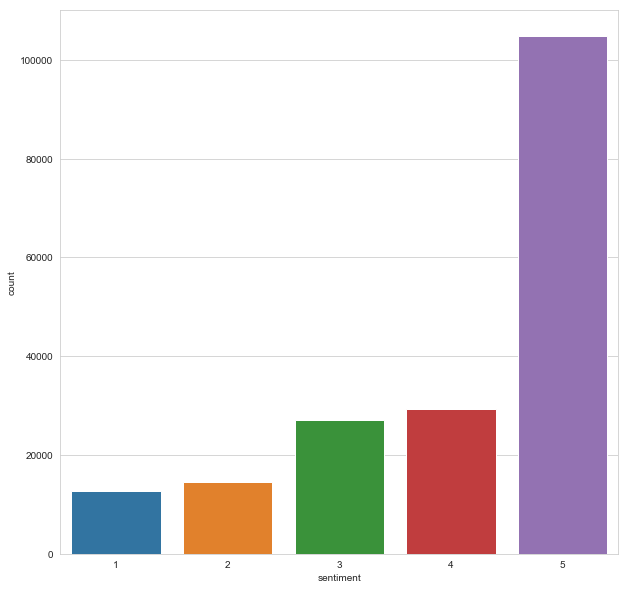

In [42]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="sentiment", data=epinion_data)

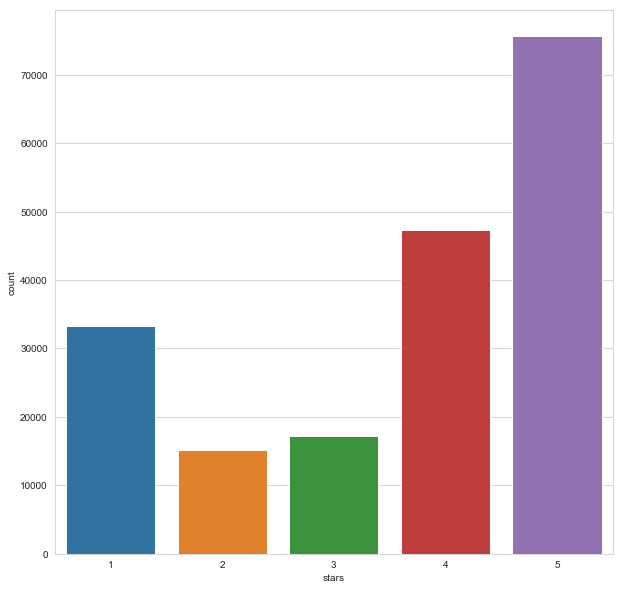

In [43]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="stars", data=epinion_data)

In [ ]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="text", data=epinion_data)

In [45]:
epinion_data.to_csv('epinion_processed_final.csv', index = False)

In [17]:
epinion_processed = pd.read_csv('epinion_processed_final.csv')

In [18]:
epinion_processed.head(3)

,item,paid,review,stars,time,user,cleaned_review,polarity,sentiment,textblob_polarity,textblob_sentiment
0,pr-Sony_KV_36FS12__Standard_Televisions,1199,well when i graduated from college it didnt ta...,5,1012262400,pyros7,well graduate college didnt take long realize ...,0.8090,5,0.312500,4
1,Minolta_QMS_PagePro_1250E_Printers,260,i got this printer from minolta as a warranty ...,4,1027296000,fgb59h,get printer minolta warranty replacement minol...,-0.0987,3,0.270833,4
2,Sony_VAIO_PCG_K45_P4_538_3_2GHz_1MB_L2_533MHz_...,1800,although i love my vaio especially the gorgeou...,2,1201305600,bucho_ky,although love vaio especially gorgeous display...,0.8883,5,0.240000,4


In [25]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in epinion_processed['cleaned_review']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
df = pd.DataFrame([list(epinion_processed['cleaned_review']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = epinion_processed.textblob_polarity.astype('float')

#https://medium.com/@himanshu_23732/sentiment-analysis-with-textblob-6bc2eb9ec4ab

KeyboardInterrupt: 

In [ ]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

//anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


KeyboardInterrupt: 

In [47]:
epinion_processed.describe()

,stars,time,polarity,sentiment,textblob_polarity,textblob_sentiment
count,188484.000000,1.884840e+05,188484.000000,188484.000000,188484.000000,188484.000000
mean,3.620010,1.124306e+09,0.466754,4.055172,0.157227,3.361521
std,1.502798,9.401768e+07,0.548216,1.270637,0.195181,0.580013
min,1.000000,9.796896e+08,-0.999700,1.000000,-1.000000,1.000000
25%,2.000000,1.048810e+09,0.000000,3.000000,0.035795,3.000000
50%,4.000000,1.117930e+09,0.690800,5.000000,0.150000,3.000000
75%,5.000000,1.188432e+09,0.925400,5.000000,0.258333,4.000000
max,5.000000,1.384387e+09,0.999900,5.000000,1.000000,5.000000


In [28]:
epinion_processed.isnull().any()

item              False
paid               True
review            False
stars             False
time              False
user               True
cleaned_review     True
polarity          False
sentiment         False
dtype: bool

In [48]:
nan_rows = epinion_processed[epinion_processed['cleaned_review'].isnull()]

In [49]:
epinion_processed = epinion_processed.dropna(subset=['cleaned_review'])

In [62]:
epinion_processed.describe()

,stars,time,polarity,sentiment,textblob_polarity,textblob_sentiment
count,188181.000000,1.881810e+05,188181.000000,188181.000000,188181.000000,188181.000000
mean,3.619303,1.124291e+09,0.467506,4.056871,0.157476,3.362098
std,1.503213,9.395927e+07,0.548337,1.270953,0.195234,0.580297
min,1.000000,9.796896e+08,-0.999700,1.000000,-1.000000,1.000000
25%,2.000000,1.048810e+09,0.000000,3.000000,0.036667,3.000000
50%,4.000000,1.117930e+09,0.690800,5.000000,0.150000,3.000000
75%,5.000000,1.188346e+09,0.925800,5.000000,0.258540,4.000000
max,5.000000,1.384387e+09,0.999900,5.000000,1.000000,5.000000


In [51]:
epinion_processed.to_csv('epinion_processed_final.csv', index = False)

https://www.kaggle.com/omkarsabnis/sentiment-analysis-on-the-yelp-reviews-dataset

https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk

https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e
